In [24]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from urllib.request import urlretrieve
from owslib.wfs import WebFeatureService
from dotenv import load_dotenv
from pyspark.sql import functions as F

# Create a spark session
spark = (
    SparkSession.builder.appName("analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

In [25]:
postcode_sdf = spark.read.parquet("../data/curated/postcodedf.parquet/")
print(postcode_sdf.count())
postcode_sdf.limit(5)

5492


postcode,sa2_code
1008,117031337
1150,117031337
2100,122031429
2200,119011571
2338,110041201


## Join postcode data with population data

In [26]:
pop_sdf = spark.read.parquet("../data/curated/pop_sdf.parquet/")
print(pop_sdf.count())
populationdf = pop_sdf.withColumnRenamed("SA2 code","sa2_code")
populationdf.limit(5)

2450


State/Terr,sa2_code,SA2 name,Total,Under 10,Adolescent,Young adult,Middle age,Old
New South Wales,101021007,Braidwood,4330,473,403,495,1472,1487
New South Wales,101021008,Karabar,8546,1082,1075,1818,2858,1713
New South Wales,101021009,Queanbeyan,11370,1275,916,3129,3681,2369
New South Wales,101021010,Queanbeyan - East,5093,588,406,1460,1718,921
New South Wales,101021012,Queanbeyan West -...,12743,1796,1910,2266,4933,1838


In [27]:
merged_sdf1 = populationdf.join(postcode_sdf, on="sa2_code", how="inner")

In [28]:
merged_sdf1.groupBy("sa2_code").count().count()

2083

Lost 367 records for which there were no sa2 codes

In [29]:
merged_sdf1.orderBy("postcode").limit(5)

sa2_code,State/Terr,SA2 name,Total,Under 10,Adolescent,Young adult,Middle age,Old,postcode
801051049,Australian Capita...,Acton,2875,6,1528,1292,47,2,0200
701011002,Northern Territory,Darwin City,7679,474,325,3322,2652,906,0800
701011002,Northern Territory,Darwin City,7679,474,325,3322,2652,906,0801
701011007,Northern Territory,Parap,2980,350,282,801,1047,500,0804
701021010,Northern Territory,Alawa,2172,326,227,529,704,386,0810


Get a single population value for each postcode and field by calculating the mean

In [30]:
postcode_pop_sdf = merged_sdf1.groupBy("postcode") \
    .agg(
        F.round(F.mean(merged_sdf1.Total), 2).alias("total_pop"),
        F.round(F.mean(merged_sdf1['Under 10']), 2).alias("under10_pop"),
        F.round(F.mean(merged_sdf1.Adolescent), 2).alias("adolsc_pop"),
        F.round(F.mean(merged_sdf1['Young adult']), 2).alias("yng_adult_pop"),
        F.round(F.mean(merged_sdf1['Middle age']), 2).alias("mid_age_pop"),
        F.round(F.mean(merged_sdf1.Old), 2).alias("old_pop")
    )
    
postcode_pop_sdf.orderBy("postcode").show()

+--------+---------+-----------+----------+-------------+-----------+-------+
|postcode|total_pop|under10_pop|adolsc_pop|yng_adult_pop|mid_age_pop|old_pop|
+--------+---------+-----------+----------+-------------+-----------+-------+
|    0200|   2875.0|        6.0|    1528.0|       1292.0|       47.0|    2.0|
|    0800|   7679.0|      474.0|     325.0|       3322.0|     2652.0|  906.0|
|    0801|   7679.0|      474.0|     325.0|       3322.0|     2652.0|  906.0|
|    0804|   2980.0|      350.0|     282.0|        801.0|     1047.0|  500.0|
|    0810|   3018.0|      419.0|    346.08|       769.08|    1013.67| 470.17|
|    0811|   3615.0|      372.0|     409.0|       1140.0|     1086.0|  608.0|
|    0812|  3314.67|     483.33|     447.0|       636.83|    1143.67| 603.83|
|    0813|   2516.0|      468.0|     454.0|        729.0|      664.0|  201.0|
|    0814|   4112.0|      490.0|     393.0|       1204.0|     1371.0|  654.0|
|    0815|   3615.0|      372.0|     409.0|       1140.0|     10

Visualize the population variation for each SA2 code within each postcode

In [31]:
pop_diffs = merged_sdf1.groupBy("postcode").agg(
    (F.max(merged_sdf1.Total) - F.min(merged_sdf1.Total)).alias("Total"),
    (F.max(merged_sdf1["Under 10"]) - F.min(merged_sdf1["Under 10"])).alias("Under 10"),
    (F.max(merged_sdf1.Adolescent) - F.min(merged_sdf1.Adolescent)).alias("Adolescent"),
    (F.max(merged_sdf1["Young adult"]) - F.min(merged_sdf1["Young adult"])).alias("Young adult"),
    (F.max(merged_sdf1["Middle age"]) - F.min(merged_sdf1["Middle age"])).alias("Middle age"),
    (F.max(merged_sdf1.Old) - F.min(merged_sdf1.Old)).alias("Old")
)

In [32]:
pop_diffs.limit(5)

postcode,Total,Under 10,Adolescent,Young adult,Middle age,Old
2294,0,0,0,0,0,0
2136,13811,1444,1638,2493,4732,3504
2069,0,0,0,0,0,0
2162,0,0,0,0,0,0
2464,0,0,0,0,0,0


/tmp/ipykernel_2980/1227780644.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['Total', 'Under 10',


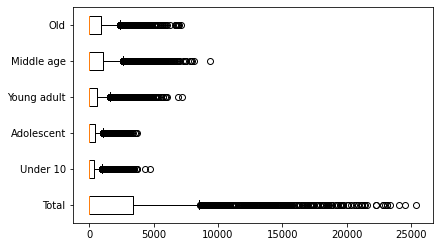

In [33]:
fig1 = plt.figure(figsize = (5, 3))
ax1 = fig1.add_axes([0, 0, 1, 1])
ax1.set_yticklabels(['Total', 'Under 10',
                    'Adolescent', 'Young adult',
                    'Middle age', 'Old'])
bp = ax1.boxplot(pop_diffs.drop("postcode").toPandas(), vert=0)

plt.show()

## Join postcode data with income data

In [34]:
incomedf = spark.read.parquet("../data/curated/incomedf.parquet/")
print(incomedf.count())
incomedf.limit(5)

2239


sa2_code,num_earners,median_age,median_income,mean_income
206041126,14398,32,51696,73634
203021046,6701,45,57818,83648
202011020,7944,47,46635,57894
208031187,3158,43,52094,58104
203021047,8152,42,47651,56636


In [35]:
merged_sdf2 = incomedf.join(postcode_sdf, on="sa2_code", how="inner")

In [36]:
merged_sdf2.groupBy("sa2_code").count().count()

2186

Lost 53 records for which there were no sa2 codes

In [37]:
merged_sdf2.orderBy("postcode").limit(5)

sa2_code,num_earners,median_age,median_income,mean_income,postcode
801051049,548,23,9306,16835,0200
701011002,5909,33,60937,87791,0800
701011002,5909,33,60937,87791,0801
701011007,1873,40,75219,98872,0804
701021010,1387,40,54188,61411,0810


Again, use the mean approach for the income data

In [38]:
postcode_income_sdf = merged_sdf2.groupBy("postcode") \
    .agg(
        F.round(F.mean(merged_sdf2.num_earners), 2).alias("num_earners"),
        F.round(F.mean(merged_sdf2.median_age), 2).alias("median_age"),
        F.round(F.mean(merged_sdf2.median_income), 2).alias("median_income"),
        F.round(F.mean(merged_sdf2.mean_income), 2).alias("mean_income")
    )
    
postcode_income_sdf.orderBy("postcode").show()

+--------+-----------+----------+-------------+-----------+
|postcode|num_earners|median_age|median_income|mean_income|
+--------+-----------+----------+-------------+-----------+
|    0200|      548.0|      23.0|       9306.0|    16835.0|
|    0800|     5909.0|      33.0|      60937.0|    87791.0|
|    0801|     5909.0|      33.0|      60937.0|    87791.0|
|    0804|     1873.0|      40.0|      75219.0|    98872.0|
|    0810|    1823.33|     39.33|      59558.0|   69537.42|
|    0811|     2395.0|      39.0|      52335.0|    67299.0|
|    0812|     2330.2|      41.6|      62069.0|    69623.6|
|    0813|      296.0|      35.0|      35787.0|    44160.0|
|    0814|     2618.0|      39.0|      65946.0|    81123.0|
|    0815|     2395.0|      39.0|      52335.0|    67299.0|
|    0820|    2223.55|     41.09|     58518.91|   75577.27|
|    0821|     3585.0|      39.0|      51942.0|    69250.0|
|    0822|    1787.38|     39.06|     49168.06|   59432.69|
|    0828|      686.0|      43.0|      5

Visualize the income variation for each SA2 code within each postcode

In [39]:
income_diffs = merged_sdf2.groupBy("postcode").agg(
    (F.max(merged_sdf2.num_earners) - F.min(merged_sdf2.num_earners)).alias("num_earners"),
    (F.max(merged_sdf2.median_age) - F.min(merged_sdf2.median_age)).alias("median_age"),
    (F.max(merged_sdf2.median_income) - F.min(merged_sdf2.median_income)).alias("median_income"),
    (F.max(merged_sdf2.mean_income) - F.min(merged_sdf2.mean_income)).alias("mean_income")
)

In [40]:
income_diffs.limit(5)

postcode,num_earners,median_age,median_income,mean_income
4032,2182,8,4402,6670
3414,0,0,0,0
9009,0,0,0,0
6240,0,0,0,0
3517,0,0,0,0


/tmp/ipykernel_2980/3120451410.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['num_earners', 'median_age',


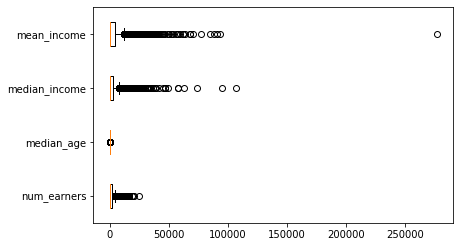

In [41]:
fig2 = plt.figure(figsize = (5, 3))
ax2 = fig2.add_axes([0, 0, 1, 1])
ax2.set_yticklabels(['num_earners', 'median_age',
                    'median_income', 'mean_income'])
bp = ax2.boxplot(income_diffs.drop("postcode").toPandas(), vert=0)

plt.show()

Combine all external data in a single spark dataframe

In [42]:
print(postcode_pop_sdf.count(), postcode_income_sdf.count())

2793 3160


In [43]:
external_data_sdf = postcode_pop_sdf.join(postcode_income_sdf, on="postcode", how="full")
print(external_data_sdf.count())
external_data_sdf.limit(5)

3162


postcode,total_pop,under10_pop,adolsc_pop,yng_adult_pop,mid_age_pop,old_pop,num_earners,median_age,median_income,mean_income
0200,2875.0,6.0,1528.0,1292.0,47.0,2.0,548.0,23.0,9306.0,16835.0
0800,7679.0,474.0,325.0,3322.0,2652.0,906.0,5909.0,33.0,60937.0,87791.0
0801,7679.0,474.0,325.0,3322.0,2652.0,906.0,5909.0,33.0,60937.0,87791.0
0804,2980.0,350.0,282.0,801.0,1047.0,500.0,1873.0,40.0,75219.0,98872.0
0810,3018.0,419.0,346.08,769.08,1013.67,470.17,1823.33,39.33,59558.0,69537.42


## Join External data with existing data

In [44]:
sdf = spark.read.parquet("../data/curated/mergedf.parquet/")
print(sdf.count())
sdf.limit(5)

13613661


merchant_abn,consumer_id,user_id,dollar_value,order_id,order_datetime,customer_name,address,state,postcode,gender,company_name,tags,take_rate,revenue_band
94472466107,30,13842,36.094519921528466,0dc80e20-901c-410...,2021-08-20,Tamara Stewart,352 Jessica Summit,VIC,3612,Female,Eu Dolor Egestas PC,"cable, satellite,...",6.23,a
21532935983,30,13842,71.1148505207073,5fbb2316-39b7-43b...,2021-08-21,Tamara Stewart,352 Jessica Summit,VIC,3612,Female,Eleifend Nec Inco...,"cable, satellite,...",5.58,a
60956456424,30,13842,56.52469841268393,60bc5068-e775-4c4...,2021-08-19,Tamara Stewart,352 Jessica Summit,VIC,3612,Female,Ultricies Digniss...,"gift, card, novel...",4.69,b
39211701585,30,13842,105.80444352294495,810594a7-c21a-4dd...,2021-08-22,Tamara Stewart,352 Jessica Summit,VIC,3612,Female,Diam Eu Dolor PC,shoe shops,4.76,b
27326652377,30,13842,1179.9080321368747,7ef554a5-02a8-435...,2021-08-22,Tamara Stewart,352 Jessica Summit,VIC,3612,Female,Tellus Aenean Cor...,music shops - mus...,6.33,a


In [45]:
finaldf = sdf.join(external_data_sdf, on="postcode", how="inner")
print(finaldf.count())
finaldf.limit(5)

13394287


postcode,merchant_abn,consumer_id,user_id,dollar_value,order_id,order_datetime,customer_name,address,state,gender,company_name,tags,take_rate,revenue_band,total_pop,under10_pop,adolsc_pop,yng_adult_pop,mid_age_pop,old_pop,num_earners,median_age,median_income,mean_income
7252,40559163709,71385,13049,499.22801818354054,753b49dc-b04a-453...,2021-08-19,Joshua Hawkins,7313 Edwards Isle...,TAS,Male,Maecenas Iaculis ...,"computers, comput...",1.50,c,5872.5,621.0,693.0,821.5,1923.0,1814.0,2756.5,48.5,44398.5,52100.5
7252,49891706470,71385,13049,27.59743014174974,19c2c44d-4d9b-4e4...,2021-08-22,Joshua Hawkins,7313 Edwards Isle...,TAS,Male,Non Vestibulum In...,tent and awning s...,5.80,a,5872.5,621.0,693.0,821.5,1923.0,1814.0,2756.5,48.5,44398.5,52100.5
7252,45629217853,71385,13049,23.56428590811388,9ff40986-52cc-47d...,2021-08-22,Joshua Hawkins,7313 Edwards Isle...,TAS,Male,Lacus Consulting,"gift, card, novel...",6.98,a,5872.5,621.0,693.0,821.5,1923.0,1814.0,2756.5,48.5,44398.5,52100.5
7252,49891706470,71385,13049,13.272207348909346,233195e0-3482-451...,2021-07-15,Joshua Hawkins,7313 Edwards Isle...,TAS,Male,Non Vestibulum In...,tent and awning s...,5.80,a,5872.5,621.0,693.0,821.5,1923.0,1814.0,2756.5,48.5,44398.5,52100.5
7252,80324045558,71385,13049,139.35678856727068,3fd87986-f437-42f...,2021-07-15,Joshua Hawkins,7313 Edwards Isle...,TAS,Male,Ipsum Dolor Sit C...,"gift, card, novel...",1.47,c,5872.5,621.0,693.0,821.5,1923.0,1814.0,2756.5,48.5,44398.5,52100.5


Null values occur because for some postcodes, population/income data did not exist.

In [46]:
finaldf = finaldf.dropna(how="any")
finaldf.count()

11818811

Removing records containing null values resulted in the loss of 1,575,476 records.